# HW - 4
    author: Найдович Олег

# Load, preprocess data

In [42]:
import numpy as np
import pandas as pd
from datetime import date, timedelta
import scipy.stats as stats

import matplotlib.pyplot as plt
import plotly.graph_objs as go

In [43]:
def preprocess_data(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s') + timedelta(hours=3)
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

    pre_group = df[df['group'].isna()]
    alpha_group = df[df['group'] == 'A']
    beta_group = df[df['group'] == 'B']

    return pre_group, alpha_group, beta_group

In [44]:
df = pd.read_csv("data.gzip", compression='gzip')
pre_group, alpha_group, beta_group = preprocess_data(df)

# Analytics

In [45]:
print(f"{pre_group['date'].min()=},   {pre_group['date'].max()=}")
print(f"{alpha_group['date'].min()=}, {alpha_group['date'].max()=}")
print(f"{beta_group['date'].min()=}, {beta_group['date'].max()=}")

pre_group['date'].min()=Timestamp('2023-04-01 00:00:00'),   pre_group['date'].max()=Timestamp('2023-04-30 00:00:00')
alpha_group['date'].min()=Timestamp('2023-05-01 00:00:00'), alpha_group['date'].max()=Timestamp('2023-05-31 00:00:00')
beta_group['date'].min()=Timestamp('2023-05-01 00:00:00'), beta_group['date'].max()=Timestamp('2023-05-31 00:00:00')


In [46]:
print(f"{pre_group['id_user'].nunique()=}")
print(f"{alpha_group['id_user'].nunique()=}")
print(f"{beta_group['id_user'].nunique()=}")

pre_group['id_user'].nunique()=10000
alpha_group['id_user'].nunique()=6000
beta_group['id_user'].nunique()=6000


In [47]:
print(f"{pre_group['id_user'].count()=}")
print(f"{alpha_group['id_user'].count()=}")
print(f"{beta_group['id_user'].count()=}")

pre_group['id_user'].count()=25759
alpha_group['id_user'].count()=15389
beta_group['id_user'].count()=15257


## Outliers detection

### Preprocessing

In [48]:
threshold = 0.02

ALPHA = 0.05
BETA = 0.2

PRE_END = pd.to_datetime('2023-04-30', format='%Y-%m-%d')
EXP_START = pd.to_datetime('2023-05-01', format='%Y-%m-%d')
EXP_END = pd.to_datetime('2023-05-31', format='%Y-%m-%d')

#### outliers detection for pre_group:

In [49]:
lower_bound = pre_group.sum_payment.quantile(q=threshold)
upper_bound = pre_group.sum_payment.quantile(q=1-threshold)
emission_df = pre_group[(pre_group.sum_payment < lower_bound) | (pre_group.sum_payment > upper_bound)]

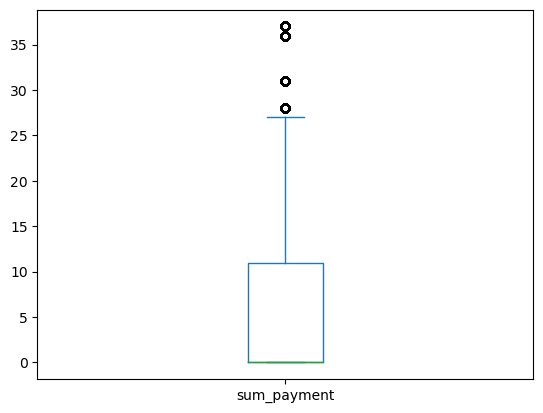

In [50]:
pre_group.loc[
    pre_group.index.isin(emission_df.index), "sum_payment"
] = pre_group.loc[pre_group.index.isin(emission_df.index), "sum_payment"].apply(lambda x: min(x, upper_bound))


_, bp = pre_group.sum_payment.plot.box(return_type='both')

#### Cacl the duration

In [62]:
def calculate_sample_size(num_groups, effect_size, std_dev_1, std_dev_2, alpha=ALPHA, beta=BETA):
    z_value = stats.norm.ppf(1 - alpha/2) + stats.norm.ppf(1 - beta)
    sample_size = (num_groups + 1) * z_value ** 2 * (std_dev_1 ** 2 + std_dev_2 ** 2 / num_groups) / (effect_size ** 2)
    return sample_size


def calculate_total_payments(data_frame, ending_date, is_experimental=False):
    filtered_data = data_frame.groupby('id_user').timestamp.min().reset_index(name='min_timestamp')
    filtered_data['max_timestamp'] = filtered_data['min_timestamp'] + timedelta(seconds=7 * 24 * 60 * 60)
    merged_data = data_frame.merge(filtered_data, on='id_user')
    filtered_data = merged_data[(merged_data['timestamp'] <= merged_data['max_timestamp']) & (merged_data['timestamp'] >= merged_data['min_timestamp'])]
    filtered_data = filtered_data[pd.to_datetime(filtered_data['max_timestamp']).dt.normalize() <= ending_date]
    
    total_payments = filtered_data.groupby('id_user').sum_payment.sum().tolist()
    return total_payments


In [65]:
total_payments = calculate_total_payments(pre_group, ending_date=PRE_END)
sigma_1 = sigma_2 = np.std(total_payments)

mean_base = np.mean(total_payments)
effect = 0.1 * mean_base

k = a_group_df['id_user'].nunique() / b_group_df['id_user'].nunique()

In [66]:
target_n = int(calculate_sample_size(k, effect, sigma_1, sigma_2, alpha=0.05, beta=0.2)/2)

In [68]:
print(target_n) # nice!!!

3570


#### data filtering:

In [75]:
def find_filtering_date(data_frame, target_count):
    start_date = EXP_START + timedelta(days=7)
    
    while start_date != EXP_END:
        temp_df = data_frame[data_frame['date'] <= start_date]
        filtered_data = temp_df.groupby('id_user').timestamp.min().reset_index(name='min_timestamp')
        filtered_data['max_timestamp'] = filtered_data['min_timestamp'] + timedelta(seconds=7 * 24 * 60 * 60)
        filtered_data = filtered_data[pd.to_datetime(filtered_data['max_timestamp']).dt.normalize() <= start_date]
        
        if filtered_data['id_user'].nunique() >= target_count:
            return start_date
        
        start_date = start_date + timedelta(days=1)
    
    return start_date

In [84]:
a_date = find_filtering_date(alpha_group, target_n)
b_date = find_filtering_date(beta_group, target_n)

if a_date == b_date:
    EXP_END = a_date
else:
    EXP_END = max(a_date, b_date)

In [87]:
alpha_group =  alpha_group[alpha_group['date'] <= EXP_END]
beta_group =  beta_group[beta_group['date'] <= EXP_END]

### Outliters detection

#### Alpha-group:

In [88]:
lower_bound = alpha_group.sum_payment.quantile(q=threshold)
upper_bound = alpha_group.sum_payment.quantile(q=1-threshold)
emission_df = alpha_group[
    (alpha_group.sum_payment < lower_bound) | (alpha_group.sum_payment > upper_bound)
]

In [91]:
alpha_group.loc[
    alpha_group.index.isin(emission_df.index), "sum_payment"
] = alpha_group.loc[alpha_group.index.isin(emission_df.index), "sum_payment"].apply(
    lambda x: min(x, upper_bound)
)

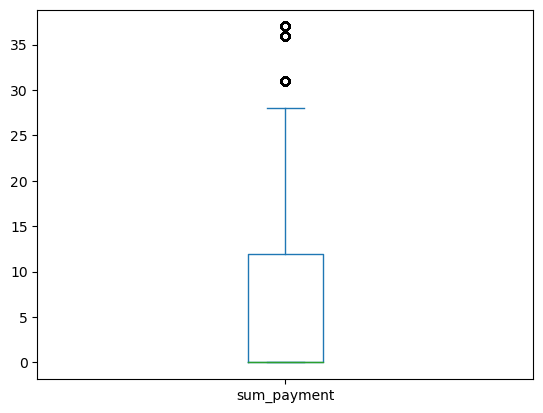

In [92]:
_, bp = alpha_group.sum_payment.plot.box(return_type='both')

#### Beta-group:

In [96]:
# сначала посмотрим на выбросы, которые кажутся прямо таки аномальными
lower_bound = beta_group.sum_payment.quantile(q=threshold)
upper_bound = beta_group.sum_payment.quantile(q=1-threshold)
emission_df = beta_group[
    (beta_group.sum_payment < lower_bound) | (beta_group.sum_payment > upper_bound)
]

In [97]:
beta_group.loc[
    beta_group.index.isin(emission_df.index), "sum_payment"
] = beta_group.loc[beta_group.index.isin(emission_df.index), "sum_payment"].apply(
    lambda x: min(x, upper_bound)
)

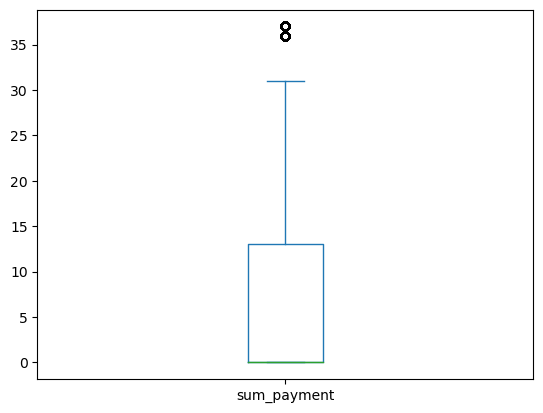

In [98]:
_, bp = beta_group.sum_payment.plot.box(return_type='both')

### Анализ эксперимента:

In [99]:
def calculate_dynamic_metric(alpha_group, beta_group):
    result_df = pd.DataFrame(columns=["metric_a", "metric_b", "effect", "t", "p_value"], index=pd.date_range(EXP_START + timedelta(days=7), EXP_END))
    
    for date in result_df.index:
        tmp_a = metric(alpha_group[alpha_group["date"] <= date], ending=date, exp=True)
        tmp_b = metric(beta_group[beta_group["date"] <= date], ending=date, exp=True)
        effect = np.mean(tmp_b) - np.mean(tmp_a)
        results = stats.ttest_ind(tmp_a, tmp_b, equal_var=abs(np.var(tmp_b) - np.var(tmp_a)) <= 0.1)
        t_value, p_value = results.statistic, results.pvalue
        result_df.loc[date] = np.mean(tmp_a), np.mean(tmp_b), effect, t_value, p_value
    
    return result_df


In [103]:
res = calculate_dynamic_metric(alpha_group, beta_group)

### Посмотрим на финальные результаты:

In [109]:
res

,metric_a,metric_b,effect,t,p_value
2023-05-08,11.5,3.333333,-8.166667,1.339292,0.206675
2023-05-09,12.586207,9.967742,-2.618465,0.650576,0.518016
2023-05-10,12.714286,10.59375,-2.120536,0.721572,0.471923
2023-05-11,11.788991,11.673077,-0.115914,0.050391,0.959862
2023-05-12,11.186747,12.709302,1.522555,-0.801269,0.423587
2023-05-13,9.91129,12.94,3.02871,-2.018334,0.044151
2023-05-14,10.171171,11.951952,1.780781,-1.419242,0.156328
2023-05-15,9.904018,11.624714,1.720696,-1.60567,0.108721
2023-05-16,10.019749,11.329044,1.309295,-1.386518,0.165883
2023-05-17,9.94387,11.203927,1.260057,-1.479031,0.139376


In [111]:
res.tail()

,metric_a,metric_b,effect,t,p_value
2023-05-27,10.621577,11.868666,1.247089,-2.651441,0.008042
2023-05-28,10.599548,12.096713,1.497165,-3.335084,0.000859
2023-05-29,10.765862,12.314217,1.548355,-3.555484,0.00038
2023-05-30,11.027027,12.411076,1.384049,-3.266765,0.001094
2023-05-31,11.281241,12.69074,1.409499,-3.368989,0.000759


# FINAL RES

In [112]:
print(f"The leading group is: {'B' if results.tail(1)['p_value'].values[0] <= ALPHA else 'A'}")

The leading group is: B
